In [1]:
from scipy.io import loadmat
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import os

## Utils

In [2]:
# util functions for sorting station (image processing part)
def intersection(line1, line2):
    # Cartesian coordinates (x1, y1, x2, y2)
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    
    # Calculate the determinant
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    if denom == 0:
        return None  # Lines are parallel or coincident
    
    # Calculate the intersection point
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    
    return (int(intersect_x), int(intersect_y))

def filter_nearby_intersections(intersections, threshold=10):
    filtered = []
    
    for point in intersections:
        add_point = True
        for filtered_point in filtered:
            # Calculate Euclidean distance between the current point and each filtered point
            dist = np.sqrt((point[0] - filtered_point[0]) ** 2 + (point[1] - filtered_point[1]) ** 2)
            if dist < threshold:
                add_point = False  # Don't add this point, it's too close to an existing one
                break
        if add_point:
            filtered.append(point)
    
    return filtered

def sort_corners(corners: list):
    # Sort the corners in a consistent order
    sorted_corners = sorted(corners, key=lambda x: (x[1], x[0]))  # Sort by y-coordinate first, then by x-coordinate
    
    # Now that we have the sorted corners, we need to assign them to top-left, top-right, bottom-left, bottom-right
    (tl, tr, br, bl) = sorted_corners
    
    # Further classify based on x-coordinate (top-left vs top-right and bottom-left vs bottom-right)
    if tl[0] > tr[0]:
        tl, tr = tr, tl
    if bl[0] > br[0]:
        bl, br = br, bl
    return [tl, tr, br, bl]

def perspective_transform(image, corners, im_size=416*3):
    # Define the width and height for the output square
    width, height = im_size, im_size
    
    # Define the destination points (square corners in the destination image)
    dst_points = np.array([
        [0, 0],  # top-left
        [width - 1, 0],  # top-right
        [width - 1, height - 1],  # bottom-right
        [0, height - 1]  # bottom-left
    ], dtype="float32")
    
    # If 4 corners are detected, proceed
    if len(corners) == 4:
        # Define the source points from the detected corners
        src_points = np.array(sort_corners(corners), dtype="float32")
        
        # Compute the perspective transform matrix
        M = cv2.getPerspectiveTransform(src_points, dst_points)
        
        # Apply the perspective transformation
        transformed_image = cv2.warpPerspective(image, M, (width, height))
        
        return transformed_image, M
    else:
        return None, None 
    
def calculate_angle(line1, line2):
    # Extract coordinates from the lines
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    
    # Calculate direction vectors
    vector1 = np.array([x2 - x1, y2 - y1])
    vector2 = np.array([x4 - x3, y4 - y3])
    
    # Compute dot product and magnitudes
    dot_product = np.dot(vector1, vector2)
    mag1 = np.linalg.norm(vector1)
    mag2 = np.linalg.norm(vector2)
    
    # Calculate the cosine of the angle
    cos_theta = dot_product / (mag1 * mag2)
    
    # Ensure cos_theta is within valid range for acos to avoid errors due to floating point precision
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def find_bounding_rectangle(blob):
    # find 4 longest lines
    edges = cv2.Canny(blob, 150, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=100)
    line_details = []
    
    # Calculate the length of each line and store the details
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            line_details.append((x1, y1, x2, y2, length))
    
    # Sort the lines by length in descending order
    line_details.sort(key=lambda x: x[4], reverse=True)

    intersections = []
    if lines is not None:
        for i in range(min(10, len(line_details))):
            for j in range(min(10, len(line_details))):
                line1 = line_details[i][0:4]
                line2 = line_details[j][0:4]
                if calculate_angle(line1, line2) < 45:
                    continue
                intersect_point = intersection(line1, line2)
                if intersect_point and 0 <= intersect_point[0] <= blob.shape[1] and 0 <= intersect_point[1] < blob.shape[0]:
                    intersections.append(intersect_point)

    filtered_intersections = filter_nearby_intersections(intersections, 30)

    return filtered_intersections

In [29]:
def detect_screw_region(im_rgb):
    im_g = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)
    im_bi = np.zeros_like(im_g)
    im_bi[im_g >= 200] = 255
    plt.imshow(im_bi, cmap="gray")
    plt.show()
    # get biggest blob
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(im_bi)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Skip the background (label 0)
    largest_component = (labels == largest_label).astype(np.uint8) * 255
    
    # fill screw holes
    cnts, hier = cv2.findContours(largest_component, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in cnts:
        cv2.drawContours(largest_component,[cnt],0,255,-1)
    plt.imshow(largest_component)
    plt.show()
    contours, _ = cv2.findContours(largest_component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Loop through each contour to fit a polygon
    contour = contours[0] # get the first and only contour
    # Approximate the polygon with a precision proportional to the perimeter
    hull = cv2.convexHull(contour)
    cv2.fillPoly(largest_component, [hull], color=255)
    plt.imshow(largest_component)
    plt.show()
    corners = find_bounding_rectangle(largest_component)
    
    if len(corners) == 4:
        screw_im, M = perspective_transform(im_rgb, corners, 416*3)
        if screw_im is not None:
           return screw_im, corners

    return None, None

## Main program

In [4]:
def detect_screws(captured_im_rgb: np.ndarray, corners: list, background_cubid_rgb: np.ndarray, min_changed_area=1000):
    screw_dict = {}
    viz_im = captured_im_rgb.copy()
    if len(corners) == 4:
        screw_im_rgb, transformed_matrix = perspective_transform(captured_im_rgb, corners, im_size=416*3)
        csize = background_cubid_rgb.shape[0]//3 
        background_cubid_g = cv2.cvtColor(background_cubid_rgb, cv2.COLOR_RGB2GRAY)
        screw_im_g = cv2.cvtColor(screw_im_rgb, cv2.COLOR_RGB2GRAY)
        diff_im = cv2.absdiff(background_cubid_g, screw_im_g)
        diff_v1 = np.zeros_like(diff_im)
        diff_v1[diff_im >= 50] = 255

        # plot grid onto the captured image
        corners = sort_corners(corners)
        cv2.line(viz_im, corners[0], corners[1], (255, 0, 0), 5)
        cv2.line(viz_im, corners[1], corners[2], (255, 0, 0), 5)
        cv2.line(viz_im, corners[2], corners[3], (255, 0, 0), 5)
        cv2.line(viz_im, corners[0], corners[3], (255, 0, 0), 5)

        tf_mtx_inv = np.linalg.inv(transformed_matrix)
        a1 = (int(corners[0][0]+1/3*(corners[3][0]-corners[0][0])), int(corners[0][1]+1/3*(corners[3][1]-corners[0][1])))
        b1 = (int(corners[1][0]+1/3*(corners[2][0]-corners[1][0])), int(corners[1][1]+1/3*(corners[2][1]-corners[1][1])))
        cv2.line(viz_im, a1, b1, (255, 0, 0), 5)
        a2 = (int(corners[0][0]+2/3*(corners[3][0]-corners[0][0])), int(corners[0][1]+2/3*(corners[3][1]-corners[0][1])))
        b2 = (int(corners[1][0]+2/3*(corners[2][0]-corners[1][0])), int(corners[1][1]+2/3*(corners[2][1]-corners[1][1])))
        cv2.line(viz_im, a2, b2, (255, 0, 0), 5)
        a3 = (int(corners[0][0]+1/3*(corners[1][0]-corners[0][0])), int(corners[0][1]+1/3*(corners[1][1]-corners[0][1])))
        b3 = (int(corners[3][0]+1/3*(corners[2][0]-corners[3][0])), int(corners[3][1]+1/3*(corners[2][1]-corners[3][1])))
        cv2.line(viz_im, a3, b3, (255, 0, 0), 5)
        a4 = (int(corners[0][0]+2/3*(corners[1][0]-corners[0][0])), int(corners[0][1]+2/3*(corners[1][1]-corners[0][1])))
        b4 = (int(corners[3][0]+2/3*(corners[2][0]-corners[3][0])), int(corners[3][1]+2/3*(corners[2][1]-corners[3][1])))
        cv2.line(viz_im, a4, b4, (255, 0, 0), 5)
        
        for r in range(3):
            for c in range(3):
                d = np.count_nonzero(diff_v1[r*csize:(r+1)*csize, c*csize:(c+1)*csize])
                if d < min_changed_area:
                    continue
                # plot a circle onto each screw for later verification
                point = np.array([(c+0.5)*416, (r+0.5)*416, 1], dtype=np.float32)
                original_point = tf_mtx_inv @ point
                x_orig = int(original_point[0] / original_point[2])
                y_orig = int(original_point[1] / original_point[2])
                cv2.circle(viz_im, [x_orig, y_orig], 8, (0,255,0), -1)
                crop_im = screw_im_rgb[r*416:(r+1)*416, c*416:(c+1)*416]
                xPos = 3-r 
                yPos = 3-c 
                screw_dict[f"{xPos}.{yPos}"] = crop_im.copy() 

    return screw_dict, viz_im

## Validate program

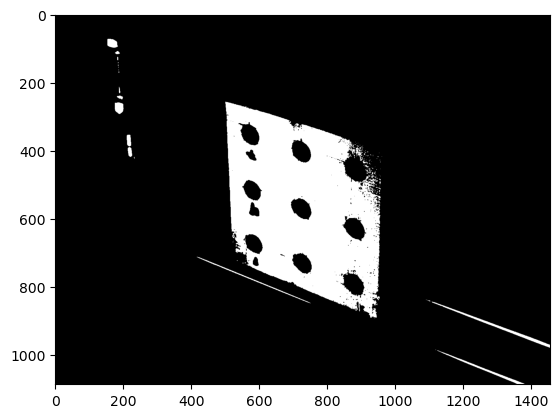

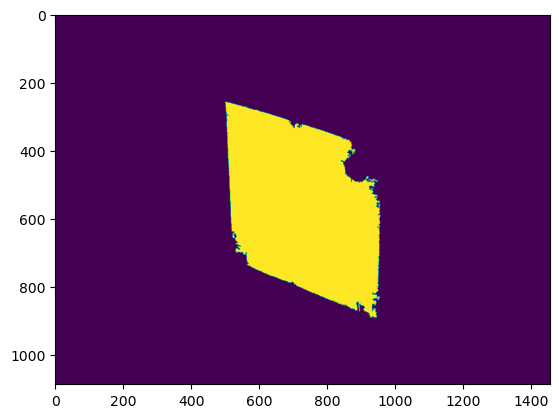

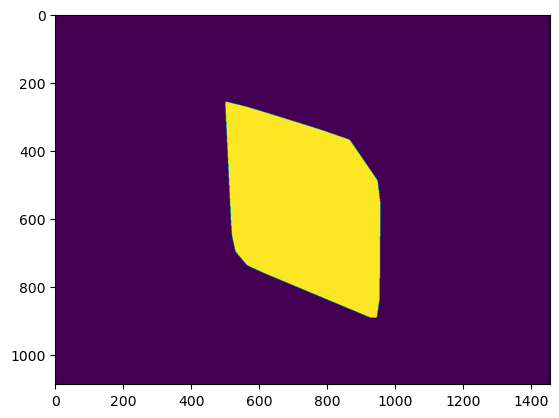

[(523, 721), (499, 252), (955, 904), (955, 392)]

In [30]:
im_dir = "templates"
image_bgr_01 = cv2.imread(os.path.join(im_dir, "sorting_station_template.png"))
background_cubid_rgb, corners = detect_screw_region(image_bgr_01[...,::-1])
corners 

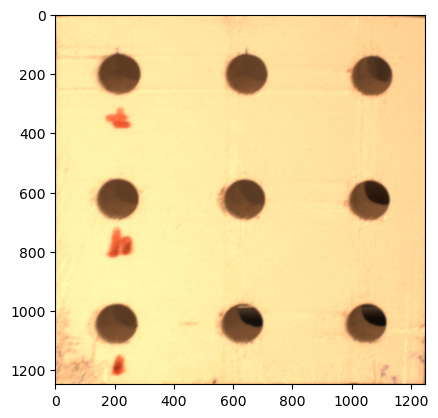

In [31]:
plt.imshow(background_cubid_rgb)

In [ ]:
im_dir = "images_17112025/pose01"
image_bgr_01 = cv2.imread(os.path.join(im_dir, "0.bmp"))
background_cubid_rgb, corners = detect_screw_region(image_bgr_01[...,::-1])
infer_bgr = cv2.imread(os.path.join(im_dir, "1.bmp"))
screw_dict, viz_im = detect_screws(infer_bgr[...,::-1], corners, background_cubid_rgb, min_changed_area=1000)

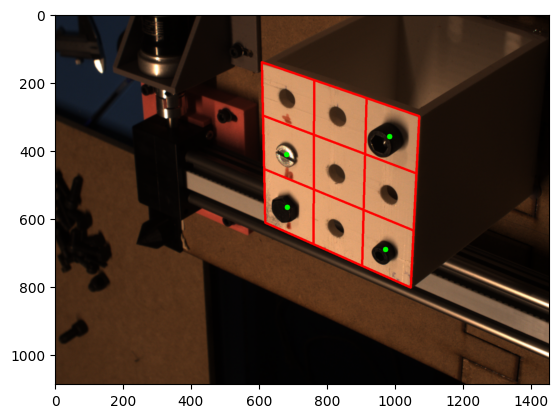

In [6]:
plt.imshow(viz_im)